# A first example
This is a first example of how to use lettuce.
A two dimensional Taylor Green vortex is initialized and simulated for 10000 steps. Afterwards the energy and the velocity field is plotted.

In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch

## Setup
* for running on GPU: device = "cuda". CUDA drivers are required!
* dtype=torch.float32 for single precision - float64 for double precision
* select collision model (here BGKCollision) - try also KBCCollision or RegularizedCollision

In [2]:
lattice = lt.Lattice(lt.D2Q9, device = "cuda", dtype=torch.float32)
flow = lt.TaylorGreenVortex2D(resolution=256, reynolds_number=100, mach_number=0.05, lattice=lattice)
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

* Reporters will grab the results in between simulation steps (see reporters.py and simulation.py)
* Output: Column 1: simulation steps, Column 2: time in LU, Column 3: kinetic energy in PU
* Output: separate VTK-file with ux,uy,(uz) and p for every 100. time step in ./output

In [3]:
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
reporter = lt.ObservableReporter(Energy, interval=1000, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=100, filename_base="./output"))

steps     time     IncompressibleKineticEnergy


## Run simulation

In [4]:
simulation.initialize_f_neq()
mlups = simulation.step(num_steps=10000)
print("Performance in MLUPS:", mlups)

Performance in MLUPS: 121.19580217150042


## Post process
### Energy Reporter
* Grab output of kinetic energy reporter

(11, 3)


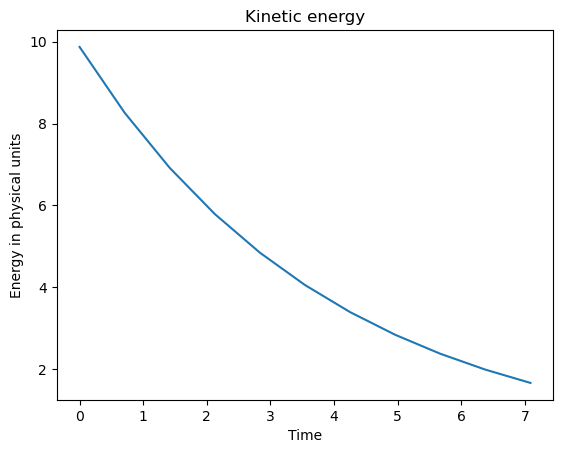

In [5]:
energy = np.array(simulation.reporters[0].out)
print(energy.shape)
plt.plot(energy[:,1],energy[:,2])
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy in physical units')
plt.show()

### Velocity
We calculate the speed in Lettuce units depending on the last 'f'. Then we convert this velocity into physical units. For further investigations the tensor must be converted into a Numpy-Array. The norm of the fractions in x and y direction is plotted afterwards.

In [6]:
u = flow.units.convert_velocity_to_pu(lattice.u(simulation.f)).numpy()
u_norm = np.linalg.norm(u,axis=0)
plt.imshow(u_norm)
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.